Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Studying the Action vectors

In [1]:
import os
from six.moves import xrange 
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage import io
from sklearn import metrics
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hcluster


# Custom scripts
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [2]:
height=112 
width=112 
channel=3
crop_size=112
cluster_length=16
feature_size=8192

####  Loading model 

In [3]:
## Defining placeholders in tf for images and targets
x_image = tf.placeholder(tf.float32, [None, cluster_length,height,width,channel],name='x') 

model_keras = md.C3D_ucf101_training_model_tf(summary=True)
out=model_keras(x_image)

print('Miscellenious items finished..!!',flush=True)

/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Tier_2/modelling.py:392: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", name="conv1", input_shape=(16, 112, ..., padding="same")`
  input_shape=input_shape))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Tier_2/modelling.py:394: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid")`
  border_mode='valid', name='pool1'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Tier_2/modelling.py:397: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", padding="same")`
  border_mode='same', name='conv2'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_Tier_2/modelling.py:399: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0         
__________

####  Feature extraction

In [4]:
## Getting 16 frames after unifrom sampling of video sample
def get_compress_frames_data(filename, num_frames_per_clip=16):
  ''' Given a directory containing extracted frames, return a video clip of
  (num_frames_per_clip) consecutive frames as a list of np arrays '''
  ret_arr = []
  for parent, dirnames, filenames in os.walk(filename):

    filenames = sorted(filenames)
    jump=math.floor((len(filenames)/num_frames_per_clip))
    loop=0
    for i in range(0,len(filenames),jump):
      if (loop>15):
        break
      if (filenames[i].endswith('.png')):
        image_name = str(filename) + '/' + str(filenames[i])
        img = Image.open(image_name)
        img_data = np.array(img)
        ret_arr.append(img_data)
        loop=loop+1
  ret_arr=np.array(ret_arr)
  #ret_arr=ret_arr/255
  return np.array(ret_arr)

In [5]:
## Feature extraction
def get_features_from_class(class_folder):
    feature_set_a=[]
    base_dir_a=class_folder
    sub_dir_a=os.listdir(base_dir_a)
    sub_dir_a=sorted(sub_dir_a)
    print(sub_dir_a)
    if '.DS_Store' in sub_dir_a:
        sub_dir_a.remove('.DS_Store')
    for sub_dir_a_ in sub_dir_a:
        vid_a=get_compress_frames_data(base_dir_a+sub_dir_a_)
        feature_set_a.append(extract_video_features(vid_a))
    return np.array(feature_set_a)

#### Load model and features

In [91]:
saved_path='/nobackup/leopauly/S2l/'
## Start the session with logging placement.
init_op = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
sess.run(init_op)

## Restore model weights from previously saved model
saver = tf.train.Saver()
saver.restore(sess, os.path.join(saved_path,'activity_model.ckpt-67'))
print("Model restored from file: %s" % saved_path,flush=True)

INFO:tensorflow:Restoring parameters from /nobackup/leopauly/S2l/activity_model.ckpt-67
Model restored from file: /nobackup/leopauly/S2l/


In [92]:
## Extraction of features 
def extract_video_features(vid):
    vid_=vid.reshape(-1,cluster_length,height,width,channel)
    f_v = sess.graph.get_tensor_by_name('flatten_1/Reshape:0') #('flatten_1/Reshape:0') #('pool4/MaxPool3D:0') #('dropout_1/cond/Merge:0') #('fc8/BiasAdd:0') 
    f_v_val=sess.run([f_v], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })#f_v_val=sess.run([y_pred], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })
    features=np.reshape(f_v_val,(-1))
    return features

In [93]:
feature_set_a=get_features_from_class('/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Push/')

['.DS_Store', 'push_demo_0deg', 'push_demo_180deg', 'push_demo_human', 'push_robo', 'push_robo_M2', 'push_robo_M3', 'push_robo_arbview1', 'push_robo_bg_fast', 'push_robo_change_pos', 'push_robo_changetarget', 'push_robo_comp0', 'push_robo_comp1', 'push_robo_comp2', 'push_robo_fast', 'push_robo_green', 'push_robo_obj2_new', 'push_robo_sideview']


In [94]:
feature_set_b=get_features_from_class('/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Reach/')

['.DS_Store', 'reach_demo_0deg', 'reach_demo_180deg', 'reach_demo_green', 'reach_human', 'reach_robo', 'reach_robo_M2', 'reach_robo_M3', 'reach_robo_arbview1', 'reach_robo_bg', 'reach_robo_change_pos', 'reach_robo_change_target', 'reach_robo_comp0', 'reach_robo_comp1', 'reach_robo_comp2', 'reach_robo_fast', 'reach_robo_obj2', 'reach_robo_sideview_new']


In [95]:
feature_set_c=get_features_from_class('/nobackup/leopauly/S2l/Leeds_Action_Dataset_6_7_2020/Reach n Push/')

['.DS_Store', 'Multi_robo_M3', 'multi_demo_0deg', 'multi_demo_180deg', 'multi_robo', 'multi_robo_M2', 'multi_robo_arbview1', 'multi_robo_bg', 'multi_robo_change_pos', 'multi_robo_change_target', 'multi_robo_comp0', 'multi_robo_comp1', 'multi_robo_comp2', 'multi_robo_fast_new', 'multi_robo_human_new', 'multi_robo_obj', 'multi_robo_obj2', 'multi_robo_sideview']


#### Clustering 

In [96]:
from sklearn.cluster import AgglomerativeClustering, Birch
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy
points=np.concatenate((feature_set_a,feature_set_b,feature_set_c),axis=0)

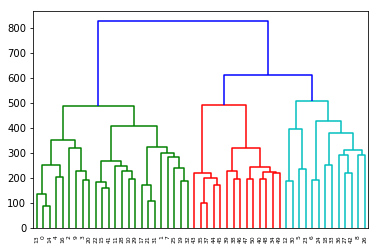

In [113]:
Z = linkage(points,'ward',)
dn = dendrogram(Z,p=100000000)
plt.show()

In [104]:
y_km = scipy.cluster.hierarchy.fclusterdata(points,3,criterion='maxclust',method='ward')

print(y_km[0:17])
print(y_km[17:34])
print(y_km[34:51])

## True labels
num_test_video_per_class=17
y_true_a=np.ones(num_test_video_per_class)*0
y_true_b=np.ones(num_test_video_per_class)*1
y_true_c=np.ones(num_test_video_per_class)*2
y_true=np.concatenate((y_true_a,y_true_b,y_true_c),axis=0)

print(y_true[0:17])
print(y_true[17:34])
print(y_true[34:51])

## Results
print('Adjusted random score:',round(metrics.adjusted_rand_score(y_true,y_km),2))
print('Adjusted mutual infromation score:',metrics.adjusted_mutual_info_score(y_true,y_km))
print('Homogeneity score:',metrics.homogeneity_score(y_true,y_km))
print('V measure score:',round(metrics.v_measure_score(y_true,y_km),2))

[1 1 1 1 1 3 3 1 3 1 1 1 3 1 1 1 1]
[1 3 1 1 1 1 3 3 1 3 3 1 1 3 1 1 3]
[2 2 3 2 2 2 2 1 3 2 2 2 2 2 2 2 2]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
Adjusted random score: 0.35
Adjusted mutual infromation score: 0.393356875157
Homogeneity score: 0.41647243658
V measure score: 0.42


In [105]:
print(Z)

[[   0.           14.           87.13724297    2.        ]
 [  35.           37.          102.20203365    2.        ]
 [  21.           31.          106.63252991    2.        ]
 [  13.           51.          136.54605328    3.        ]
 [  15.           41.          160.37473764    2.        ]
 [  44.           45.          170.6910108     2.        ]
 [  17.           53.          174.06487651    3.        ]
 [  22.           55.          184.40541056    3.        ]
 [  19.           32.          189.05071715    2.        ]
 [  12.           30.          189.20845004    2.        ]
 [   3.           20.          190.93191901    2.        ]
 [   6.           24.          192.62801399    2.        ]
 [  47.           50.          196.47663222    2.        ]
 [  38.           46.          197.75117738    2.        ]
 [  40.           48.          198.3055357     2.        ]
 [  10.           29.          198.4229356     2.        ]
 [  52.           56.          201.4075818     4.       